## Построение графов взаимодействий

**Задание 1.** Прочитайте из файла ```Грибоедов Александр. Горе от ума.txt``` пьесу. В начале текстового файла будут перечисленны героини пьесы, создайте список основных действующих лиц. Далее разделите пьесу на действия, а действия на явления. Для каждого явления получите список участвующих в нём персонажей и длину его реплики в словах. Какую структуру вы выберите для хранения данной информации?

In [1]:
import re
import numpy as np

from itertools import chain

with open('Грибоедов Александр. Горе от ума.txt') as fl:
    piece = fl.read()
    
heroes = [re.sub('\.', '', hero).strip() for hero in piece.split('\n\n\n')[1].split('\n')]
heroes

['Павел Афанасьевич Фамусов , управляющий в казённом месте',
 'Софья Павловна , дочь его',
 'Лизанька , служанка',
 'Алексей Степанович Молчалин , секретарь Фамусова, живущий у него в доме',
 'Александр Андреевич Чацкий',
 'Полковник Скалозуб, Сергей Сергеевич',
 'Наталья Дмитриевна , молодая дама, Платон Михайлович , муж её — Горичи',
 'Князь Тугоуховский  и княгиня , жена его, с шестью дочерями',
 'Графиня-бабушка, Графиня-внучка  — Хрюмины',
 'Антон Антонович Загорецкий',
 'Старуха Хлёстова,  свояченица Фамусова',
 'Г N',
 'Г D',
 'Репетилов',
 'Петрушка  и несколько говорящих слуг',
 'Множество гостей всякого разбора и их лакеев при разъезде',
 'Официанты Фамусова']

In [2]:
def get_horoes(action, heroes):
    action_heros = {}
    
    items = [re.sub('\n\(.*\) \n', '', item).strip() for item in action.split('\n\n\n')]
    for item in items:
        item = item.split('\n')
        
        hero = item[0].strip()
        if hero == 'София': hero = 'Софья'
        if hero == 'Лизанька': hero = 'Лиза'
        
        speach = ' '.join(item[1:]).strip()
        if not(speach and np.any([hero in hero_ for hero_ in heroes])):
            continue
            
        action_heros.setdefault(hero, 0)
        action_heros[hero] += len(re.findall('\w\w+', speach.lower()))
    
    return action_heros

In [3]:
actions = re.split('ДЕЙСТВИЕ [IV]{1,2}', piece)[1:]
actions = [action.strip() for action in actions]
actions = [[item.strip() for item in re.split('Явление \d{1,2}', action) if item.strip()]
           for action in actions]
actions = [[((i, j), item) for j, item in enumerate(action, 1)] 
           for i, action in enumerate(actions, 1)]
actions = list(chain(*actions))
actions = [(number, get_horoes(action, heroes)) for number, action in actions]

**Задание 2**. После выполнения первого задания у вас должна быть реализована структура, из которой вы сможете для каждого действия и каждого явления определить, какие персонажи в нём участвовали. Выведите на экран список уникальных персонажей, которых вам удалось выделить в пьесе. Сколько таких персонажей? 

Замечание: Список уникальных персонажей вы должно получить с помощью одной строчки кода =) 

In [4]:
heroes = np.unique(np.hstack([list(action_heroes.keys()) for _, action_heroes in actions]))
print('; '.join(heroes))

Графиня-бабушка; Графиня-внучка; Загорецкий; Князь; Лиза; Молчалин; Наталья Дмитриевна; Платон Михайлович; Репетилов; Скалозуб; Софья; Фамусов; Хлёстова; Чацкий


**Задание 3.** Формирование матрицы взаимодействий.

Будем считать, что персонажи вступили во взаимодействие, если они вместе участвовали в явлении. 

Пусть у нас $N$ уникальных персонажей. Создайте квадратную матрицу из нулей разъмера N. Каждому персонажу присвойте номер от $0$ до $N-1$.

Тогда, если в некотором явление участвовал список персонажей $\{n_1, n_2, n3\}$, то значения матрицы взаимодействий $A$ обновляются следующим образом:

$$A[i, j] = A[i, j] + 1$$ где $i \neq j \in \{n_1, n_2, n3\}$

Уникальные номера персонажам присвойте с помощью [LabelEncoder](sklearn.preprocessing.LabelEncoder)

Матрицу взаимосвязей визуализируйте с помощью [matshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.matshow.html#matplotlib.pyplot.matshow). А также воспользуйтесь [colorbar](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.colorbar.html) и [xticks/yticks](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xticks.html)

Какие персонажи чаще всего взаимодействуют?

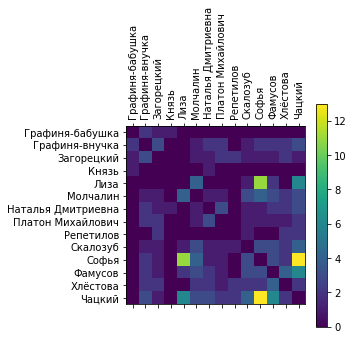

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import combinations
from sklearn.preprocessing import LabelEncoder

actions_heroes = [list(action_heroes.keys()) for _, action_heroes in actions]

le = LabelEncoder().fit(np.hstack(actions_heroes))

actions_heroes = [le.transform(action_heroes) 
                  for action_heroes in actions_heroes if action_heroes]

N = le.classes_.shape[0]
A = np.zeros((N, N))

for action_heroes in actions_heroes:
    for i, j in combinations(action_heroes, 2):
        A[i, j] += 1
        A[j, i] += 1


plt.matshow(A)
plt.colorbar()

plt.xticks(np.arange(N), le.classes_, rotation=90)
plt.yticks(np.arange(N), le.classes_)

plt.show()

**Задание 4.** Постройте граф взаимасвязей с помощью [NetworkX](https://pypi.org/project/networkx/) ([Хабрахабра](https://habrahabr.ru/post/125898/))

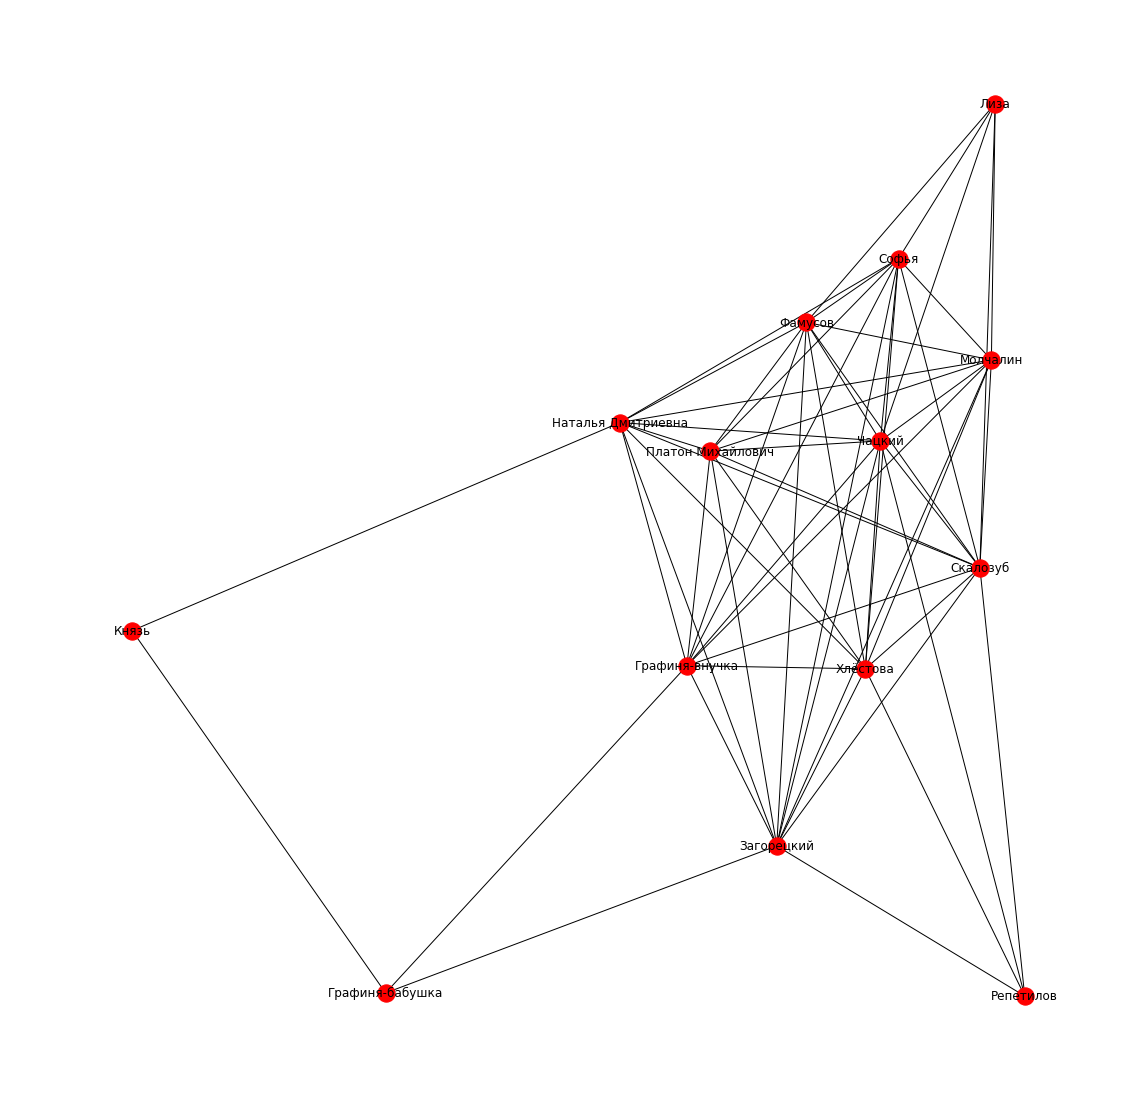

In [11]:
import networkx as nx

G = nx.Graph(A/A.max())

plt.figure(figsize=(15, 15))
nx.draw(G, labels = dict(zip(range(N), le.classes_)), with_labels = True)
plt.show()

**Задание 5.** Вспомним, что в первом задании мы так же сохраняли информацию о том, сколько слов произнёс каждый персонаж. 

Пусть в некотором явлении участвовало некоторое подмножество персонажей и мы знаем их вес -- количество слов: $\{n_1:w_1, n_2:w_2, n_3:w3\}$. Также допустим, что $w_1 > w_2, w_1 > w3$ -- первый действующий персонаж произнёс больше всех слов. 

Тогда считаем, что персонаж $n_1$ воздействовал на персонажей $n_2$ и $n_3$. Преобразуем матрицу взаимодействий следующим образом:

$$ A[n_1, j] = A[n_1, j] + 1 $$ где $j \in \{n_2, n_3\}$

Таким образом матрица $A$ получится не симметричной, а соответсвующий граф взаимодействий направленным.

Нарисуте граф взаимодействий